<div class="alert alert-block alert-info">NB: This notebook is based on [Fastai Notebook Lesson 8](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb) </div>

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import time
t0 = time.clock()
time.ctime(time.time())

'Sat May  5 21:04:25 2018'

In [3]:
import torch
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0.4.0


In [4]:
from fastai.dataset import open_image
from fastai.conv_learner import *
from fastai.transforms import tfms_from_model

import json
import numpy as np
from matplotlib import patches, patheffects

## Pascal VOC

We will use the [Pascal VOC](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We use the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

### Preliminaries: Preparing the data

We use [pathlib](https://docs.python.org/3/library/pathlib.html) for our paths and file access. NB: it returns an OS-specific class (on Linux, `PosixPath`). Most libraries that take paths as input can take a pathlib object. 
But some (like `cv2`) can't, then use `str()` to convert it to a string.  [Pathlib Cheat sheet](http://path%20%3D%20path%28%27data/pascal%27%29%20list%28PATH.iterdir%28%29%29)

In [5]:
from pathlib import Path
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/.SRC'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/VOC2007_doc.pdf'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/models')]

A [JSON version](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip) of hand-labeled *annotations* - *bounding boxes* show where each object is. 

In [6]:
version = "2007" #"2012"
JFN = str(PATH)+"/pascal_train"+version+".json"
with open(JFN) as jf:
    trn_j = json.load(jf)  
print(trn_j.keys())

dict_keys(['images', 'type', 'annotations', 'categories'])


Lets create dataframes for categories, images and annotations

We use pandas to organize the data. See the [Gist](https://gist.github.com/binga/1bc4ebe5e41f670f5954d2ffa9d6c0ed) for details. 


In [7]:
import pandas as pd
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']            
categories = pd.DataFrame(trn_j[CATEGORIES])
annotations = pd.DataFrame(trn_j[ANNOTATIONS])
images = pd.DataFrame(trn_j[IMAGES])

len(categories), len(images), len (annotations)

(20, 2501, 7844)

Each image has a unique ID.

In [8]:
images.head(1)

file_name  height  id  width
0  000012.jpg     333  12    500

In [9]:
cats = categories.name #; cats[:5] 
categories.head(1)

id       name supercategory
0   1  aeroplane          none

In [10]:
annotations.head(2)

area                 bbox  category_id  id  ignore  image_id  iscrowd  \
0  34104  [155, 96, 196, 174]            7   1       0        12        0   
1  13110   [184, 61, 95, 138]           15   2       0        17        0   

                               segmentation  
0  [[155, 96, 155, 270, 351, 270, 351, 96]]  
1  [[184, 61, 184, 199, 279, 199, 279, 61]]

In [11]:
annotations.shape

(7844, 8)

Remove all the rows where there is an "ignore == 1" column, else some of them will appear as the "largest boxes."





In [12]:
annotations = annotations[annotations.ignore != 1]

annotations.shape

(6301, 8)

Annotations fields:
- **bbox** : Top Left coordinates, column (eg 155), row (e.g. 96), height (196), width (174)
- **image_id** : to later join with images df to find file_name etc.
- **category_id** : see trn_j[CATEGORIES] (below)
- **segmentation** : polygon segmentation (we will be using them)
- **ignore** : we will ignore the ignore flags
- **iscrowd** : specifies that it is a crowd of that object, not just one of them

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [13]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX, AREA, NAME = 'file_name','id','image_id','category_id','bbox', 'area', 'name'

In [14]:
trn_fns = images.file_name
trn_ids = images.id 
len(trn_fns), trn_fns[0], trn_ids[0]

(2501, '000012.jpg', 12)

### Review the input Files

In [15]:
VOCDIR = 'VOCdevkit/VOC' + version
list((PATH/VOCDIR).iterdir())  

[PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')]

In [16]:
JPEGS = VOCDIR+'/JPEGImages'
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:3]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008795.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008222.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008472.jpg')]

In [17]:
data = (annotations
        .merge(categories, how='left', left_on=CAT_ID, right_on=ID)
        .merge(images, how='left', left_on=IMG_ID, right_on=ID))
data.head(1)

area                 bbox  category_id  id_x  ignore  image_id  iscrowd  \
0  34104  [155, 96, 196, 174]            7     1       0        12        0   

                               segmentation  id_y name supercategory  \
0  [[155, 96, 155, 270, 351, 270, 351, 96]]     7  car          none   

    file_name  height  id  width  
0  000012.jpg     333  12    500

Remove all the rows where there is an "ignore == 1" column, else some of them could appear as the "largest boxes."

In [18]:
data = data[data.ignore != 1] 

print (data.shape)

(6301, 15)


In [19]:
# what are the image_id, bbox and categories of the first top entries?
data[['image_id','bbox', 'name']].head()

image_id                  bbox     name
0        12   [155, 96, 196, 174]      car
1        17    [184, 61, 95, 138]   person
2        17    [89, 77, 314, 259]    horse
3        23    [8, 229, 237, 271]  bicycle
4        23  [229, 219, 105, 281]  bicycle

Notice that some images, e.g., `image_id` {17, 23}, have more than one annotation.

### Coordinates: Convertion and  back.

In computer vision, “my screen is 640 by 480” means 640 width by 480 height. <br>
In math, “an array is 640 by 480” means 640 rows by 480 columns. 
The Python Image Library (PIL) does things a-la-vision, ie, in width by height or columns by rows. 
But numpy is 'a-la-math' rows by columns.  <br>
In this example (and in fastai?) we describe images using the top-left xy coordinate and the bottom right xy coordinate, rather than Pascal's way of top left x, y, height, width.

We use `bb_hw(a)` to convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

TL = Top Left, BR = Bottom Right
- VOC Format: `bbox` : TL.column, TL.row, height, width
- Fastai format: `hw_bb`: TL.row, TL.column, BR.row = (TL.row + width -1), BR.column = (TL.column + height - 1)

However, some libs take VOC format bounding boxes, so `hw_bb(b)` lets us convert back when required:

In [20]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])   # to Fastai bounding-box to height-width

def hw_bb(b): return np.array([b[1], b[0], b[3]+b[1]-1, b[2]+b[0]-1]) # return to VOC bounding-box

In [21]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

### Explore Images

In [22]:
def fn_from_id(id): 
    return images[images[ID] == id][FILE_NAME].values[0]

fn_from_id(12), trn_fns[0], data[FILE_NAME][0]

('000012.jpg', '000012.jpg', '000012.jpg')

In [23]:
fn = trn_fns[0]  # filename of first image
im = open_image(IMG_PATH/fn)   # open_image to later display it.

Fastai `open_image()` uses [OpenCV](https://opencv.org/). 
**<font color=red>Warning: Using Pillow or Pytorch image libraries will slow things down a lot (not multi-threaded).</font> **

In [24]:
from matplotlib import pyplot as plt

Matplotlib's `plt.subplots` is a useful wrapper for creating plots, regardless of whether you have more than one subplot. It returns an axis on the 2nd parameter.  `show_img` uses some of the (optional) OO API of Matplotlib.  Unfortunately, few use this good OO API.

In [25]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)   # if it was not passed, create one
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

### Drawing function definitions
**NB:** There are functions called `draw_*`, e.g., `draw_text` inside fastai/sgdr.py  
Those get imported by conv_learner... to avoid conflict, make sure not to import that after defining these, or consider renaming these with a prefix, e.g. `gsg_`

A simple (but rarely used) trick to making text (or bounding lines) more visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [26]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). It takes a list as input, and **expands it into actual positional arguments** in the function call. Below it is a (little) shortcut compared to writing out `b[-2],b[-1]`.

In [27]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [28]:
def draw_text(ax, xy, txt, sz=14):
    #pdb.set_trace()
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

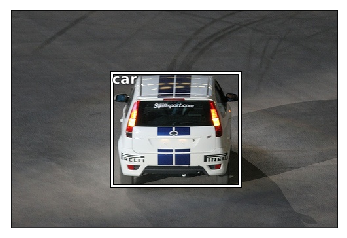

In [29]:
ax = show_img(im)
b = data['bbox'][0]  #Fastai had bb_hw(im0_a[0]), since it needed to undue the conversion. bbox has the original
draw_rect(ax, b)
draw_text(ax, b[:2], data['name'][0]) # b[:2] is the (x, y) coordinates that define the top left

In [30]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:   # ann has the bbox (original format), and the category (c)
        draw_rect(ax, b)
        draw_text(ax, b[:2], c, sz=16)

In [31]:
def draw_idx(i):   # i is the index of the image
    im_a = data[data[IMG_ID]==i][[BBOX, NAME]].values
    fn = images[images[ID] == i][FILE_NAME].values[0]
    im = open_image(IMG_PATH/fn) 
    draw_im(im, im_a)

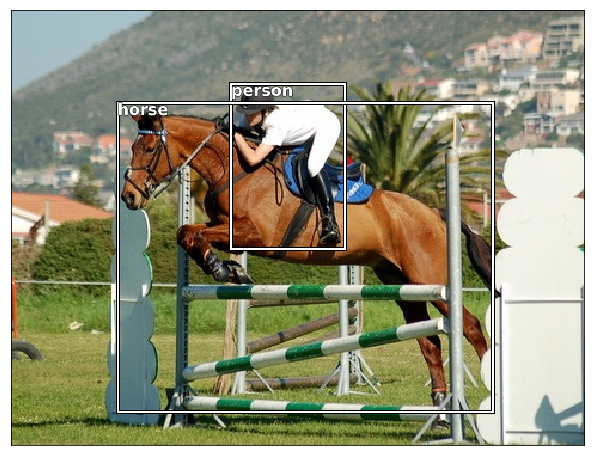

In [32]:
draw_idx(17)

## Largest item classifier

### Use pandas to get a DF with the largest box for each image

**Best Practice:** Use pandas to create a CSV of the data to model, rather than trying to create a custom dataset. 

In [33]:
largest_bbox = data.pivot_table(index='file_name', values='area', aggfunc=max).reset_index()
largest_bbox = largest_bbox.merge(data[[AREA, BBOX, IMG_ID, FILE_NAME, NAME]], how='left')
print("If these are not equal, we may have duplicates",  largest_bbox.shape[0], len(trn_fns)) 
largest_bbox.head(1)

If these are not equal, we may have duplicates 2502 2501


file_name   area                 bbox  image_id name
0  000012.jpg  34104  [155, 96, 196, 174]        12  car

In [34]:
largest_bbox.drop_duplicates(subset='file_name', inplace=True) ; largest_bbox.shape[0]

2501

Now lets create 2 new columns: `bbox_new` which follows the Fastai $<TL_y, TL_x, BR_y, BR_x>$ convention, (TL= Top Left, BR=Bottom Right), and add a `bbox_str` column which formats it as a space-separated string.

In [35]:
def bb_hw_pandas(x):
    return [x[1], x[0], x[1]+x[3]-1, x[0]+x[2]-1]

largest_bbox['bbox_new'] = largest_bbox['bbox'].apply(lambda x: bb_hw_pandas(x))
largest_bbox['bbox_str'] = largest_bbox['bbox_new'].apply(lambda x: ' '.join(str(y) for y in x))
largest_bbox.head(2)

file_name   area                 bbox  image_id   name  \
0  000012.jpg  34104  [155, 96, 196, 174]        12    car   
1  000017.jpg  81326   [89, 77, 314, 259]        17  horse   

              bbox_new        bbox_str  
0  [96, 155, 269, 350]  96 155 269 350  
1   [77, 89, 335, 402]   77 89 335 402

### Sample image with large box

In [36]:
def largest_bb_c_from_id(i): 
    pr = largest_bbox[largest_bbox['image_id'] == i]
    return pr.bbox.values[0], pr.name.values[0]

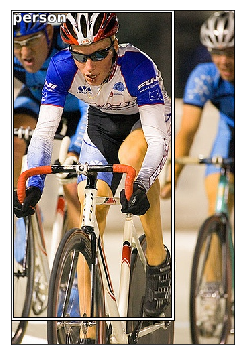

In [37]:
p = 23  # cyclist
b, c = largest_bb_c_from_id(p) 
fn = fn_from_id(p) 
ax = show_img(open_image(IMG_PATH/fn), figsize=(4,8))
draw_rect(ax, b)
draw_text(ax, b[:2], c, sz=14)

### Save to a CSV file only the columns we need (file_name and class)

In [38]:
(PATH/'tmp').mkdir(exist_ok=True)
C_CSV = PATH/'tmp/lrg.csv'

largest_bbox[[FILE_NAME, NAME]].to_csv(C_CSV, index=False)
largest_bbox[[FILE_NAME, NAME]].head()

file_name       name
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

## Prepare Deep Learning Model using ConvNet

In [39]:
f_model = resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

Notice that `crop_type=CropType.NO` , i.e. we will not crop the image. 
Previously we were cropping... because the items where mostly big and in the middle of the image.
But for bounding boxes we do not want to do that.
Usually models work better with crop rather than squish... but here it is ok.

The default strategy for creating 224 by 224 image in fast.ai is to first resize it so that the smallest side is 224. 
Then to take a random squared crop during the training. 
During validation, we take the center crop unless we use data augmentation.

For bounding boxes, we do **not** want to crop because (unlike an Imagenet where the thing we care about is pretty much in the middle and pretty big), a lot of the things in object detection are quite small and close to the edge. By setting crop_type to CropType.NO, it will not crop and therefore, to make it square, it squishes it [1:32:09]. 

In [40]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, C_CSV, tfms=tfms)

### Explore the Training set
Below we apply Python's `next(iter(md.val_dl))` to grab a (mini)batch from the model (md) validation data loader (val_dl), where (x: independent variable, y: dependent variable):

In [41]:
x,y=next(iter(md.val_dl))   # the data loader gives a minibatch of the size bs (64)

**NB:** We canot send x as-is to `show_image`, because x:
- is not an np.array, but a Tensor.
- is not in the CPU, but in the GPU.
- shape is "wrong" (3x224x224) for openCV. 
- it is not normalized. (ImageNet pre-trained models, eg Resnet, expect data to have been normalized (0 mean and 1 standard deviation)

To address these issues with the $x$ input and get it ready to be passed to a pre-trained model, we need to  
`denorm()`  does the denormalize and also fixes up dimension order, etc. 
Denormalization depends on the transform [1:37:52], and the dataset knows which transform was used to create it.
So we invoke `md.val_ds.denorm` and pass it the mini-batch after turning it into numpy array via `to_np`:

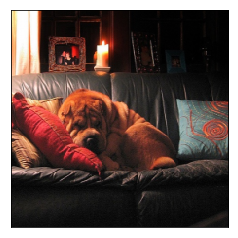

In [42]:
p = 1 # image_id in the current minibatch
show_img(md.val_ds.denorm(to_np(x))[p]);

## Start Deep Learning 
(as usual in Fastai)

In [43]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

/home/german/DeepLearning/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


### Learning Rate

In [44]:
lrf=learn.lr_find(1e-5,100)

 78%|███████▊  | 25/32 [00:05<00:01,  4.94it/s, loss=10.5]


When you LR finder graph looks like this, you can ask for more points on each end:

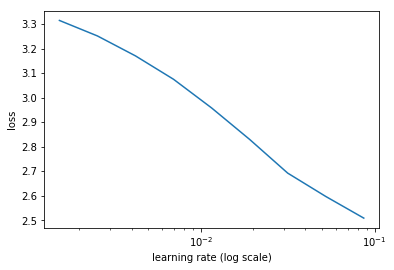

In [45]:
learn.sched.plot()

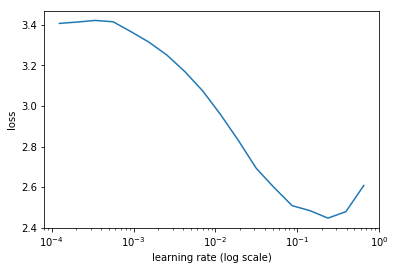

In [46]:
learn.sched.plot(n_skip=5, n_skip_end=1)   # now it looks better.

In [47]:
lr = 2e-2

### Fit

In [48]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.287547   0.640625   0.812     



[0.6406246612071991, 0.8120000023841858]

In [49]:
lrs = np.array([lr/1000,lr/100,lr])

In [50]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:07<00:01,  3.53it/s, loss=3.98] 


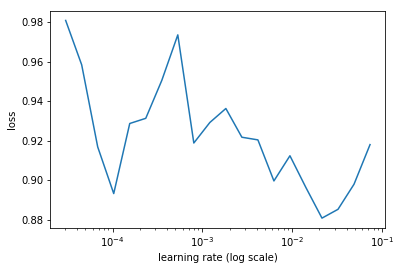

In [51]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [52]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.771576   0.547101   0.828     



[0.5471008670330048, 0.8280000023841858]

In [53]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be very hard (impossible?) to be more accurate.

In [54]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.686246   0.593546   0.826     
    1      0.468164   0.544823   0.832                     



[0.5448228871822357, 0.8320000009536743]

In [55]:
learn.save('clas_one')
learn.load('clas_one')

### Make some predictions over the validation set

In [56]:
x,y = next(iter(md.val_dl))   # Get a minibatch from validation loader
probs = F.softmax(predict_batch(learn.model, x), -1)   # Probabilities of the classes
x,preds = to_np(x),to_np(probs) # convert to np
preds = np.argmax(preds, -1) # get the predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


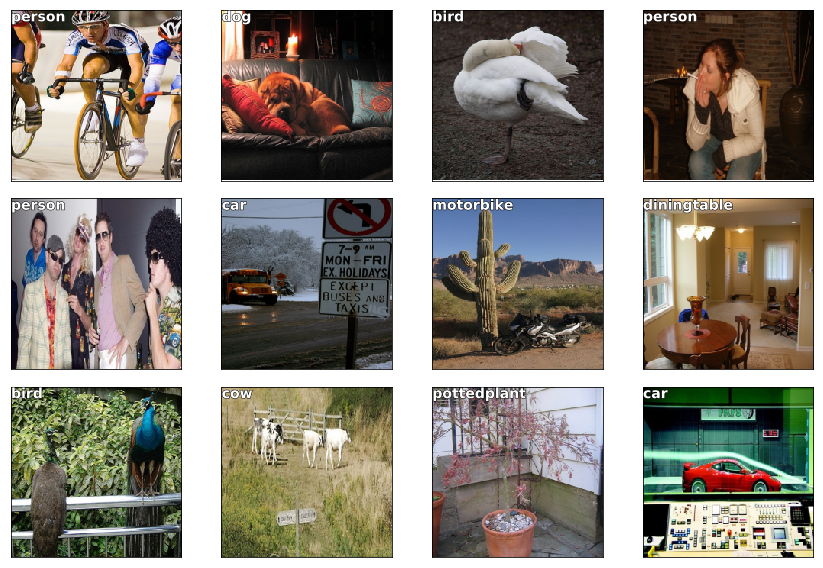

In [57]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    c = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), c)
plt.tight_layout()

It's doing a pretty good job of classifying the largest object!

## Create a bounding box around the largest object (Bbox only)

Creating a bounding box around the largest object may seem like something new...but it is not. 
We can create a `regression` rather than a classification NN. 
`Classification` NN is the one that has a sigmoid or softmax output, and we use a cross entropy, binary cross entropy, or negative log likelihood loss function. That is basically what makes it a classifier. 

If we don’t have the softmax or sigmoid at the end and we use mean squared error as a loss function, it is now a `regression` model which predicts a continuous number rather than a category. 
We also know that we can have multiple outputs (like in the planet competition, multiple classification). 
Lets combine the two ideas and do a multiple column regression.

Now we'll try to find the bounding box of the largest object. 
This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.
Thinking about it like `differentiable programming`. 
It is not *“how do I create a bounding box model?”* but rather: 
We need 4 numbers, therefore, we need a NN with 4 activations.
For loss function, we need  a function that when it is lower means that the four numbers are better? 
Mean squared loss function!

In [58]:
BB_CSV = PATH/"tmp/bb.csv"
largest_bbox[['file_name', 'bbox_str']].to_csv(BB_CSV, index=False)
largest_bbox[['file_name', 'bbox_str']].head(2)

file_name        bbox_str
0  000012.jpg  96 155 269 350
1  000017.jpg   77 89 335 402

In [59]:
largest_bbox.shape

(2501, 7)

In [60]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.<br>
Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.<br>
Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, to avoid accidentally cropping some of the objects. (This is less of an issue in Imagenet, where there is a single object to classify, and it's generally large and centrally located).

## Augmentations

fastai augmentations all start with (prefix) Random

In [61]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

**NB: Awkward terminology in fastai:**
A **classifier** is anything with dependent variable is categorical or binomial. 
**Regression** is anything with dependent variable is continuous. 
fastai naming is now confusing but will be fixed, eventually. 
Here, continuous is True because our dependent variable is the coordinates of a bounding box — 
hence the model generated is actually a regressor, not a classifier....
Lets call the model `mdR` to avoid confusions.

In [62]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
mdR = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

In [63]:
x,y = next(iter(mdR.val_dl))  # get a minibatch of data

In [64]:
idx=3
ima=mdR.val_ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[idx]))
print(b)

[115.  63. 241. 312.]


In [65]:
tfm_y = TfmType.COORD

In [66]:
def display_augs_image(augs):
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
    mdR2 = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)
    idx = 3
    fig,axes = plt.subplots(3,3, figsize=(9,9))
    for i,ax in enumerate(axes.flat):
        x,y=next(iter(mdR2.aug_dl))
        ima=mdR2.val_ds.denorm(to_np(x))[idx]
        b = bb_hw(to_np(y[idx]))
        print(b)
        show_img(ima, ax=ax)
        draw_rect(ax, b)

[ 52.  38. 107. 185.]
[ 52.  38. 107. 185.]
[ 52.  38. 107. 185.]
[ 52.  38. 107. 185.]
[ 52.  38. 107. 185.]
[ 52.  38. 107. 185.]
[ 52.  38. 107. 185.]
[ 52.  38. 107. 185.]
[ 52.  38. 107. 185.]


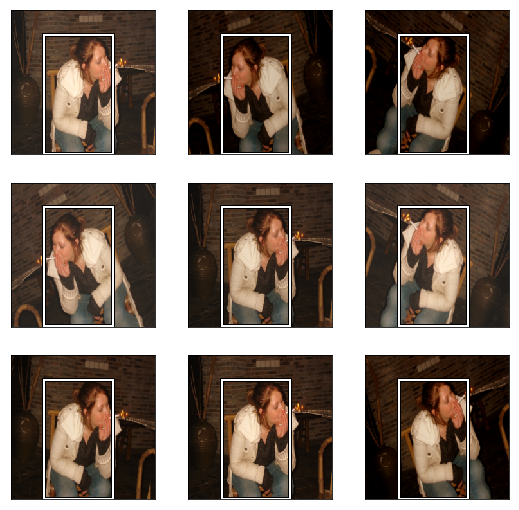

In [67]:
display_augs_image(augs)

The image gets rotated and lighting varies, but bounding box is (a) not moving and (b) is in a wrong spot [6:17]. 
This is the problem with data augmentations when the dependent variable (the box) is pixel values or in some way connected to the independent variable — they need to be augmented together. 
As you can see in the bounding box coordinates [ 115. 63. 241. 312.] , our image is 224 by 224 — so it is neither scaled nor cropped. 
The dependent variable needs to go through all the geometric transformation as the independent variables.

To do this [7:10], every transformation has an optional `tfm_y` parameter, which takes a TfmType enum value. The `TfmType.COORD` indicates that the $y$ value represents coordinates. This needs to be added to all the augmentations as well as tfms_from_model which is responsible for cropping, zooming, resizing, padding, etc.

[ 33.  17. 157. 206.]
[ 34.  19. 155. 204.]
[ 51.  17. 143. 206.]
[ 66.  38. 105. 183.]
[ 21.   9. 158. 214.]
[ 51.  36. 108. 186.]
[ 52.  38. 106. 183.]
[ 58.  26. 126. 197.]
[ 36.  19. 153. 204.]


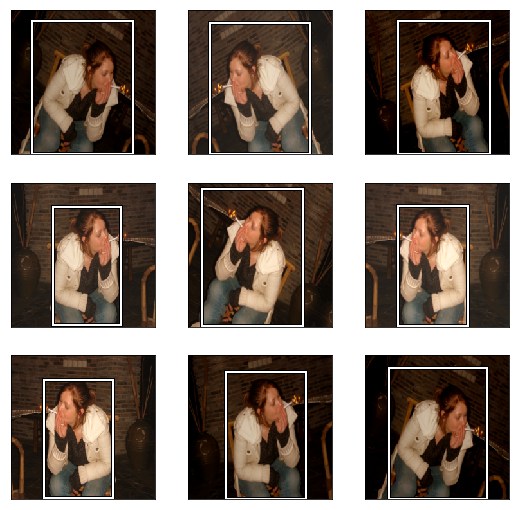

In [68]:
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(30, tfm_y=tfm_y),
        RandomLighting(0.1,0.1, tfm_y=tfm_y)]
display_augs_image(augs)

Now, the bounding box moves with the image and is in the right spot. You may notice that sometimes it looks odd like the middle on in the bottom row. This is the constraint of the information we have. If the object occupied the corners of the original bounding box, your new bounding box needs to be bigger after the image rotates. So you must be careful of not doing too "higher" rotations with bounding boxes because there is not enough information for them to stay accurate. If we were doing polygons or segmentations, we would not have this problem.

[ 52.  38. 106. 184.]
[ 64.  37. 109. 186.]
[ 52.  38. 106. 183.]
[ 51.  36. 107. 186.]
[ 52.  38. 106. 183.]
[ 52.  37. 107. 185.]
[ 66.  38. 105. 183.]
[ 66.  38. 105. 183.]
[ 65.  37. 108. 185.]


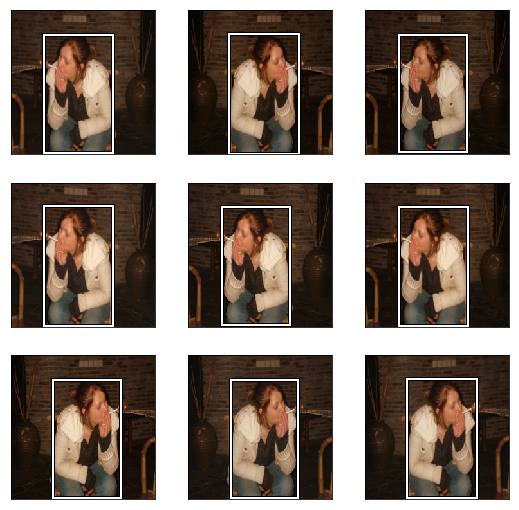

In [69]:
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]
display_augs_image(augs)

So above, we do a maximum of 3 degree rotation to avoid this problem [9:14]. It also only rotates half of the time (p=0.5).

## Custom Head
fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [70]:
#Reset the models and parameters
#bs = 64
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

Normally the previous layer has $7*7*512=2508$ in ResNet34, so flatten that out into a single vector of length 2508

In [71]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

NB: Rather than adding up the squared errors, we add up the absolute values of the errors. 
Adding up the squared errors penalizes bad misses by too much. 
So `L1Loss` is generally better.

`learn.summary()` will run a small batch of data through a model and prints out the size of tensors at every layer. Right before the Flatten layer, the tensor has the shape of $512 by 7 by 7$. 
So if it were a rank 1 tensor (i.e. a single vector) its length will be $25088 = (512 * 7 * 7)$, and that is why our custom header’s input size is 25088. 
Output size is 4 since it is the bounding box coordinates.

In [72]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

 78%|███████▊  | 25/32 [00:06<00:01,  3.85it/s, loss=467] 


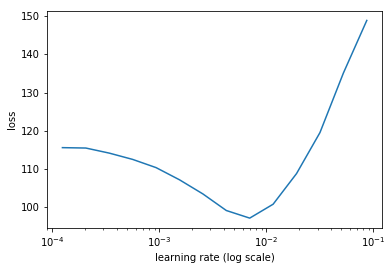

In [73]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [74]:
lr = 2e-3

learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      49.83893   35.050078 
    1      37.855162  28.571875                           
    2      31.974182  27.878492                           



[27.87849200439453]

In [75]:
lrs = np.array([lr/100,lr/10,lr])

In [76]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss                            
    0      80.56959   1.4196612948740024e+18



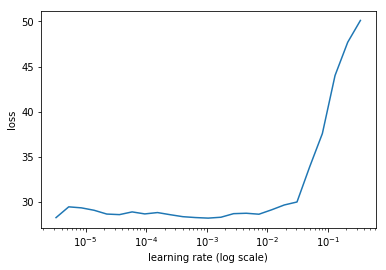

In [77]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [78]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      26.339105  23.538243 
    1      23.610649  21.231203                           
    2      20.040521  20.080773                           



[20.080772888183592]

In [79]:
learn.freeze_to(-3)

In [80]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      19.645722  22.216876 
    1      17.203285  19.676605                           



[19.67660453796387]

In [81]:
learn.save('reg4')
learn.load('reg4')

In [82]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


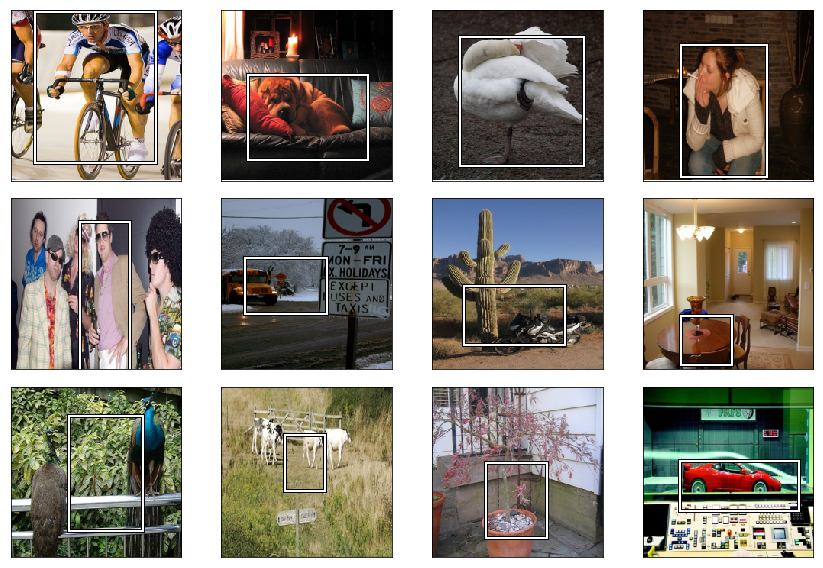

In [83]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection
Let’s combine the two to create something that can classify and localize the largest object in each image.<br>
There are 3 things that we need to do to train a neural network:
1. Data
1. Architecture
1. Loss Function

###  Providing Data
We need a ModelData object whose independent variable is the images, and dependent variable is a tuple of bounding box coordinates and class labels. 
There are several ways to do this, but here is a particularly lazy and convinient way JH came up.<br>
Create two ModelData objects representing the two different dependent variables (`mdBB` with bounding boxes coordinates, `mdC2` with classes).

**NB**: The CSV files had an extra line with a duplicate entry for a 2nd "largest" box of the same size<br>
000657.jpg,191 233 211 290<br>
000657.jpg,155 252 175 309<br>

In [84]:
df1 = pd.read_csv(BB_CSV)
df2 = pd.read_csv(C_CSV)

df1.shape, df2.shape

((2501, 2), (2501, 2))

#### Define the 2 Models

In [85]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [86]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)

In [87]:
mdBB = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

mdC2 = ImageClassifierData.from_csv(PATH, JPEGS, C_CSV, tfms=tfms_from_model(f_model, sz))

#### Concatenate labels

A dataset can be anything with `__len__` and `__getitem__` (indexer). <br>
Here's a dataset that adds a 2nd label to an existing dataset:

In [88]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

Above:
- `ds` : contains both independent and dependent variables
- `y2` : contains the additional dependent variables
- `(x, (y,self.y2[i]))` : \__getitem___ returns an independent variable and the combination of two dependent variables. <br>
We’ll use it to add the classes to the bounding boxes labels.

In [89]:
trn_ds2 = ConcatLblDataset(mdBB.trn_ds, mdC2.trn_y)
val_ds2 = ConcatLblDataset(mdBB.val_ds, mdC2.val_y)

#### Replace and test the loaders

In [90]:
mdBB.trn_dl.dataset = trn_ds2
mdBB.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

Below test these loaders with a minibatch of data to confirm that they work.

In [91]:
x,y=next(iter(mdBB.val_dl))
pidx=7
ima=mdBB.val_ds.ds.denorm(to_np(x))[pidx]
b = bb_hw(to_np(y[0][pidx])); b      # b now has the original VOC format for a box

array([ 19., 159., 105.,  64.])

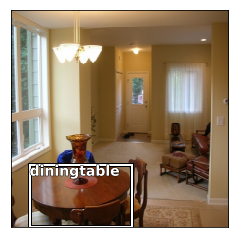

In [92]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], mdC2.classes[y[1][pidx]])

###  Choosing Architecture
The architecture will be the same as the one we used for the classifier and bounding box regression, but we will combine them.<br> 
If we have c classes, then the number of activations we need in the final layer is 4 plus c, ie `4 + len(cats)`.
4 for bounding box coordinates and c probabilities (one per class).

We will use an extra linear layer this time, plus some dropout, to help us train a more flexible model. 
In general, we want our custom head to be capable of solving the problem on its own if the pre-trained backbone it is connected to is appropriate. 
So in this case, we are trying to do quite a bit — classifier and bounding box regression, 
so just the single linear layer does not seem enough. 

In [93]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(mdBB, models)
learn.opt_fn = optim.Adam

Notice that after the first `nn.ReLu()` there is no Batchnorm.  JH checked and Resnet already has it, so it is not necessary. Similar to the head before... more complex.

### Loss Function 
[15:46]
The loss function needs to look at these 4 + len(cats) activations and decide if they are good — whether these numbers accurately reflect the position and class of the largest object in the image. 
For the first 4 activations, we will use `L1Loss` just like we did before (L1Loss is like a Mean Squared Error — instead of sum of squared errors, it uses sum of absolute values). 
For rest of the activations, we can use cross entropy loss.

Pytorch loss-functions always call their parameters: `input` and `target`.

In [94]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # JH looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

- **input** : activations
- **target** : ground truth

- **bb_t** is bounding box coordinates of target
- **c_t** are the classes of the target 
- **bb_i** is the bounding box of the input
- **c_i** is the classes probabilities of the input


- bb_t,c_t = target : This assignment will destructure the classes accordingly.

- bb_i,c_i = `input[:, :4], input[:, 4:]` :  the first ":" is for the batch dimension, then the corresponding 4  from the input is for the dimension and classes.

- b_i = `F.sigmoid(bb_i)*224` : we know our image is 224 by 224. Sigmoid will force it to be between 0 and 1, and multiply it by 224 to help our neural net to be in the range of what it has to be.

With the inputs and targets, we can calculate the L1 loss and add the cross entropy [20:39], to get our loss function:

`F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20`

Cross entropy and L1loss may be of very different scales — in which case, the larger will dominate the loss function. 
JH looked at the values and found out that if we multiply cross entropy by 20 that makes them about the same scale.  (**TODO: Is there a good function to do such calibration automatically?**)

### Start Learning

 97%|█████████▋| 31/32 [00:07<00:00,  4.34it/s, loss=1.29e+03]


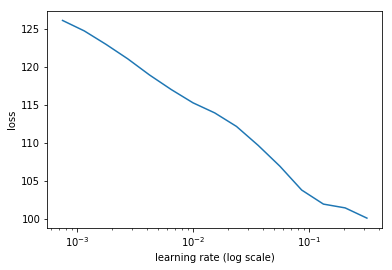

In [95]:
learn.lr_find()
learn.sched.plot()

In [96]:
lr=1e-2

In [97]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      72.73205   44.626157  0.792      31.222277 
    1      52.90176   36.307652  0.828      25.268698     
    2      43.945435  35.229184  0.848      24.569658     



[35.22918377685547, 0.8479999990463257, 24.56965754699707]

In [98]:
learn.save('reg1_0')

In [99]:
learn.freeze_to(-2)

In [100]:
lrs = np.array([lr/100, lr/10, lr])

 91%|█████████ | 29/32 [00:08<00:00,  3.33it/s, loss=201] 


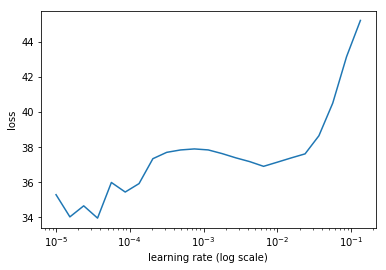

In [101]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [102]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      37.26436   36.747622  0.78       22.995655 
    1      31.776121  31.916454  0.824      20.980227     
    2      27.517928  31.343072  0.838      20.368982     
    3      24.144667  30.211108  0.84       19.619689     
    4      21.669255  30.415017  0.838      19.340128     



[30.415017486572264, 0.8380000009536743, 19.34012825012207]

In [103]:
learn.save('reg1_1')
learn.load('reg1_1')

In [104]:
learn.unfreeze()

In [105]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      18.977889  30.392428  0.832      19.411139 
    1      18.515281  30.985899  0.824      19.245329     
    2      17.883686  30.888975  0.828      19.382522     
    3      16.930258  31.124733  0.834      19.117846     
    4      16.186469  31.01413   0.828      18.961906     
    5      15.487561  30.90542   0.824      18.335644     
    6      14.706805  30.46771   0.814      18.299688     
    7      13.982823  30.625007  0.822      18.576691     
    8      13.367423  30.110399  0.82       18.217591     
    9      12.916885  30.157562  0.828      18.196614     



[30.15756199645996, 0.8280000028610229, 18.19661354827881]

Detection accuracy is in the 80’s (as before). 
Not surprising, as ResNet was designed to do classification, and explicitly to not care about geometry. 
Resnet takes the last $7*7$ grid of activations, averages them all together throwing away all the information about where everything came from.
Hence wouldn’t expect to be able to improve things for bounding box regression in such a simple way. 

Interestingly, <font color=blue>when we do accuracy (classification) and bounding box at the same time, the L1 seems a little bit better than when we just do bounding box regression</font> 
[22:46]. 
This may sound counterintuitive, but it is a really **important idea:** 
Finding what is the main object in an image is the hard part. 
Then figuring out exactly where the bounding box is, and what class it is, is easier. 
We have a single network that is both saying (a) what is and (b) where is the object.
So it is going to efficiently share all the computation about finding the object. 
When we back propagate the errors in the class (a) and in the place (b), 
that will help in finding the biggest object. 
We have multiple tasks which share some concept of what those tasks need to do to complete their work.
It is very likely they should share at least some layers of the network together. 
Later we will look at a model where most of the layers are shared, except for the last one.

In [106]:
learn.save('reg1')
learn.load('reg1')

In [107]:
y = learn.predict()
x,_ = next(iter(mdBB.val_dl))

The `expit` function, also known as the logistic function, is defined as expit(x) = 1/(1+exp(-x)). It is the inverse of the logit function.

In [108]:
from scipy.special import expit

In [109]:
x.shape, *b

(torch.Size([64, 3, 224, 224]), 19.0, 159.0, 105.0, 64.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


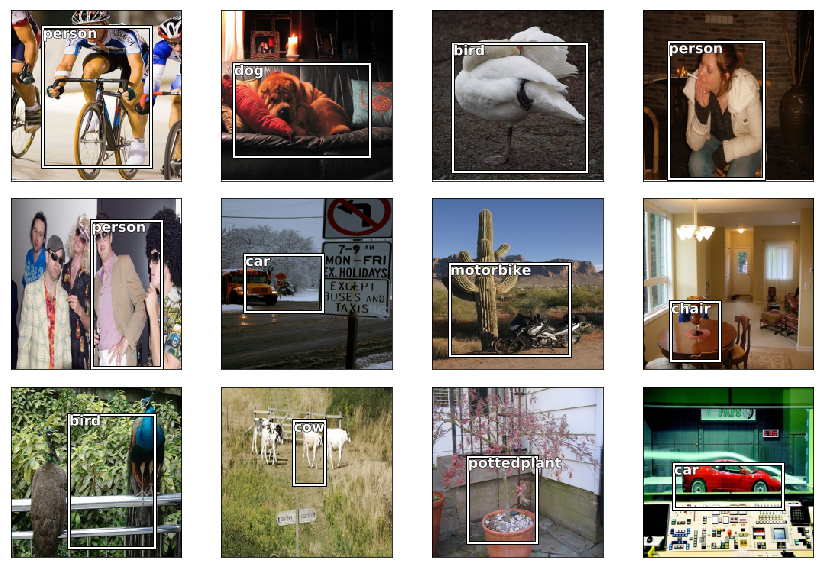

In [110]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=mdBB.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], mdC2.classes[c]) 
plt.tight_layout()

Here are the result [24:34]. 
As before, it does a good job when there is single major object in the image. Sometimes it gets a bit confused. When there are 2 birds, it "finds" one where there is none, etc.

In [111]:
t1 = time.clock()
time.ctime(time.time()), (t1 - t0)

('Sat May  5 21:11:36 2018', 3221.961058)

## End